In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy import stats
from scipy.special import expit as logistic

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
plt.style.use("dark_background")

%watermark -n -u -v -iv -w

Last updated: Mon Aug 22 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

pymc      : 4.1.3
pandas    : 1.4.3
matplotlib: 3.5.2
arviz     : 0.12.1
sys       : 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) 
[Clang 13.0.1 ]
numpy     : 1.22.4
scipy     : 1.8.1

Watermark: 2.3.1



13.1 multilevel models

In [19]:
d = pd.read_csv("Data/reedfrogs.csv", sep=',')
d.info()
d.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   density   48 non-null     int64  
 1   pred      48 non-null     object 
 2   size      48 non-null     object 
 3   surv      48 non-null     int64  
 4   propsurv  48 non-null     float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.0+ KB


,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


In [27]:
## separate intercept for each tank (row)
with pm.Model() as m1:
    ## a (intercept) is log-odds of survival
    a = pm.Normal("a", 0, 1.5, shape=len(d.index))
    ## aggregated/pooled binomial model; p is p(survival)
    p = pm.Deterministic("p", pm.math.invlogit(a[d.index.values]))
    ## N = density, logit(p) = a[tank], x = surv
    S = pm.Binomial("survived", d["density"], p, observed=d["surv"])
    trace1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


In [29]:
az.summary(trace1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],1.719,0.788,0.180,3.173,0.009,0.008,8606.0,2717.0,1.0
a[1],2.398,0.882,0.756,4.023,0.011,0.009,7127.0,2860.0,1.0
a[2],0.748,0.651,-0.397,2.058,0.008,0.008,7392.0,2788.0,1.0
a[3],2.410,0.926,0.760,4.165,0.011,0.010,8257.0,2776.0,1.0
a[4],1.714,0.768,0.326,3.197,0.009,0.008,7541.0,2984.0,1.0
...,...,...,...,...,...,...,...,...,...
p[43],0.405,0.079,0.255,0.548,0.001,0.001,7959.0,3190.0,1.0
p[44],0.622,0.081,0.473,0.769,0.001,0.001,8437.0,2615.0,1.0
p[45],0.352,0.077,0.212,0.496,0.001,0.001,8539.0,2463.0,1.0
p[46],0.860,0.056,0.754,0.954,0.001,0.000,8697.0,2998.0,1.0


In [35]:
## multi-level model
with pm.Model() as m2:
    a_bar = pm.Normal("a_bar", 0, 1.5)
    sigma = pm.Exponential("sigma", 1)
    ## all tank intercepts come from a common distribution
    a = pm.Normal("a", a_bar, sigma, shape=len(d.index))
    ## aggregated/pooled binomial model
    p = pm.Deterministic("p", pm.math.invlogit(a[d.index.values]))
    ## N = density, logit(p) = a[tank], x = surv
    S = pm.Binomial("survived", d["density"], p, observed=d["surv"])
    trace2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [40]:
az.compare({"m1": trace1, "m2": trace2},
    ic="waic", scale="deviance", method="BB-pseudo-BMA")

/Users/sasha/miniforge3/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/sasha/miniforge3/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m2,0,200.402324,21.126092,0.000000,0.996956,4.526026,0.000000,True,deviance
m1,1,214.912930,25.741074,14.510606,0.003044,7.263351,3.721246,True,deviance


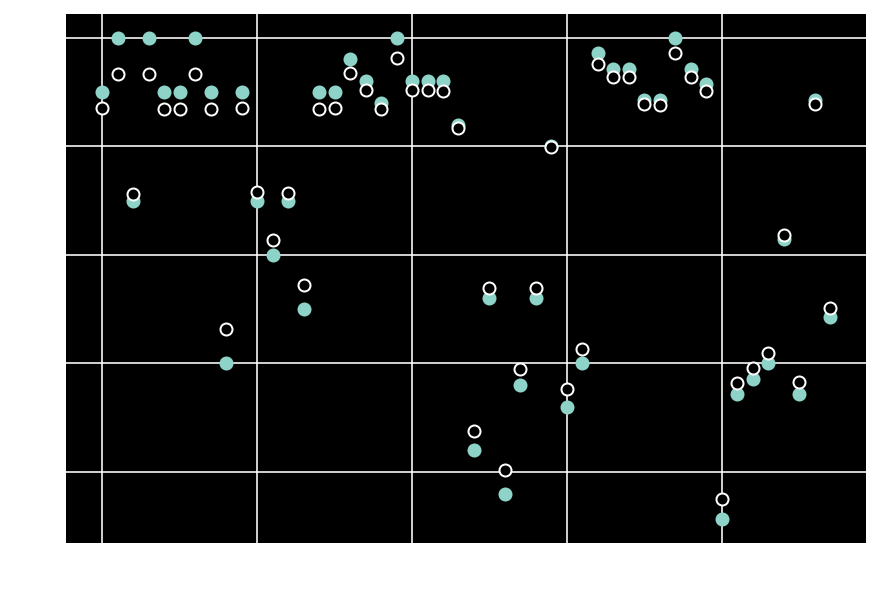

In [54]:
## illustrate shrinkage
##  note more shrinkage for tanks with low N 
##    (and more shrinkage for tanks farther from global mean)
_, ax = plt.subplots()
ax.scatter(d.index.values, d["propsurv"], marker="o")
ax.scatter(d.index.values, trace2.posterior["p"].mean(["chain","draw"]), marker="o", color="k", edgecolor="w")

13.2 simulation

In [94]:
## simulated reality using set parameter values
frogsim = {}
frogsim['a_bar'] = 1.5
frogsim['sigma'] = 1.5
frogsim['Ni'] = np.repeat([5,10,15,35],15)
frogsim['nponds'] = len(frogsim['Ni'])
frogsim['pond'] = np.arange(frogsim['nponds'])

In [95]:
## generate log-odds survival (a) for each pond
frogsim['a_pond'] = np.random.normal(frogsim['a_bar'], frogsim['sigma'], frogsim['nponds'])
frogsim['p_pond'] = logistic(frogsim['a_pond'])

In [96]:
## n surivors ~ Binomal(Ni, p)
##   (numpy function pairs each element of Ni with each element of a_pond)
frogsim['Si'] = np.random.binomial(frogsim['Ni'], frogsim['p_pond'])
frogsim['prop_surv'] = frogsim['Si']/frogsim['Ni']

In [103]:
with pm.Model() as m3:
    a_bar = pm.Normal("a_bar", 0, 1.5)
    sigma = pm.Exponential("sigma", 1)
    a = pm.Normal("a", a_bar, sigma, shape=frogsim['nponds'])
    p = pm.Deterministic("p", pm.math.invlogit(a[frogsim['pond']]))
    S = pm.Binomial("n_surv", frogsim['Ni'], p, observed=frogsim['Si'])
    trace3 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [105]:
az.summary(trace3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,1.506,0.219,1.109,1.928,0.004,0.003,2544.0,2316.0,1.0
a[0],1.537,0.899,-0.082,3.259,0.012,0.011,5917.0,3059.0,1.0
a[1],1.567,0.925,0.028,3.465,0.014,0.012,4578.0,2382.0,1.0
a[2],2.512,1.111,0.527,4.614,0.019,0.016,3935.0,2515.0,1.0
a[3],0.828,0.825,-0.630,2.450,0.010,0.010,7349.0,3153.0,1.0
...,...,...,...,...,...,...,...,...,...
p[55],0.644,0.078,0.489,0.781,0.001,0.001,5917.0,2814.0,1.0
p[56],0.565,0.077,0.426,0.710,0.001,0.001,5930.0,3318.0,1.0
p[57],0.901,0.045,0.814,0.974,0.001,0.000,5952.0,2885.0,1.0
p[58],0.723,0.071,0.591,0.858,0.001,0.001,7117.0,2825.0,1.0


In [112]:
frogsim['pm3post'] = trace3.posterior["p"].mean(["chain","draw"])

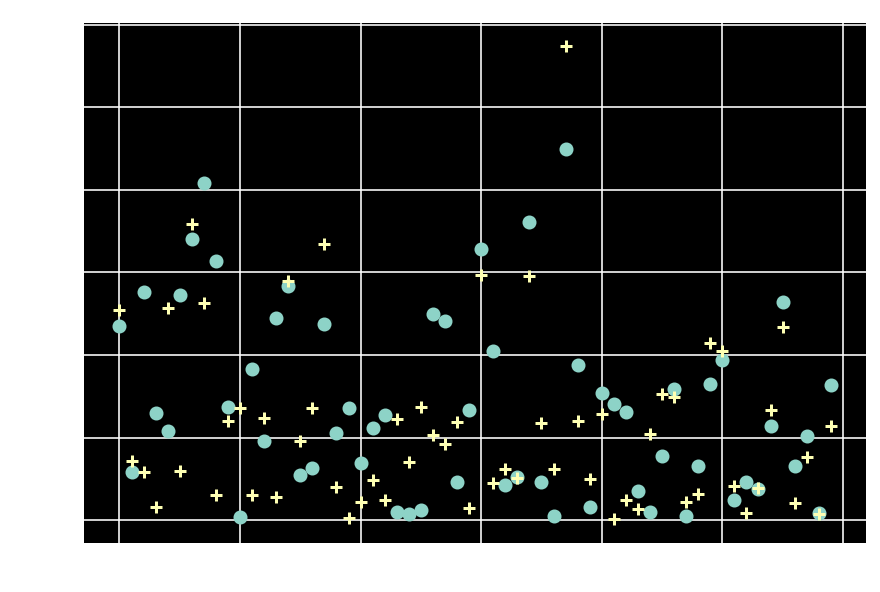

In [123]:
nopool_err = np.abs(frogsim['prop_surv'] - frogsim['p_pond'])
m3_err = np.abs(frogsim['pm3post']- frogsim['p_pond'])
_, ax = plt.subplots()
ax.scatter(frogsim['pond'], nopool_err)
ax.scatter(frogsim['pond'], m3_err, marker='+')

In [4]:
d = pd.read_csv("Data/chimpanzees.csv", sep=';')
d["actor"] -= 1
d["treatment"] = d["prosoc_left"] + 2*d["condition"]
d.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
0,0,NaN,0,1,2,0,1,0,0
1,0,NaN,0,1,4,0,0,1,0
2,0,NaN,0,1,6,1,0,0,1
3,0,NaN,0,1,8,0,1,0,0
4,0,NaN,0,1,10,1,1,1,1


In [5]:
actor_idx, actors = pd.factorize(d["actor"])
treatment_idx, treatments = pd.factorize(d["treatment"])
block_idx, blocks = pd.factorize(d["block"])

In [6]:
with pm.Model() as m4:
    ## Normal(a_bar, s_a) = common distribution for actor effect
    a_bar = pm.Normal("a_bar", 0, 1.5) 
    s_a = pm.Exponential("s_a", 1)
    ## Normal(0, s_g) = common distrib for additional effect of block
    s_g = pm.Exponential("s_g", 1) 
    ## intercepts for each actor, block, and treatment
    a = pm.Normal("a", a_bar, s_a, shape=len(actors))
    g = pm.Normal("g", 0, s_g, shape=len(blocks))
    b = pm.Normal("b", 0, 0.5, shape=len(treatments))
    p = pm.Deterministic("p", pm.math.invlogit(a[actor_idx] + g[block_idx] + b[treatment_idx]))
    L = pm.Binomial("pulled_left", 1, p, observed=d["pulled_left"])
    trace4 = pm.sample(tune=2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, s_a, s_g, a, g, b]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

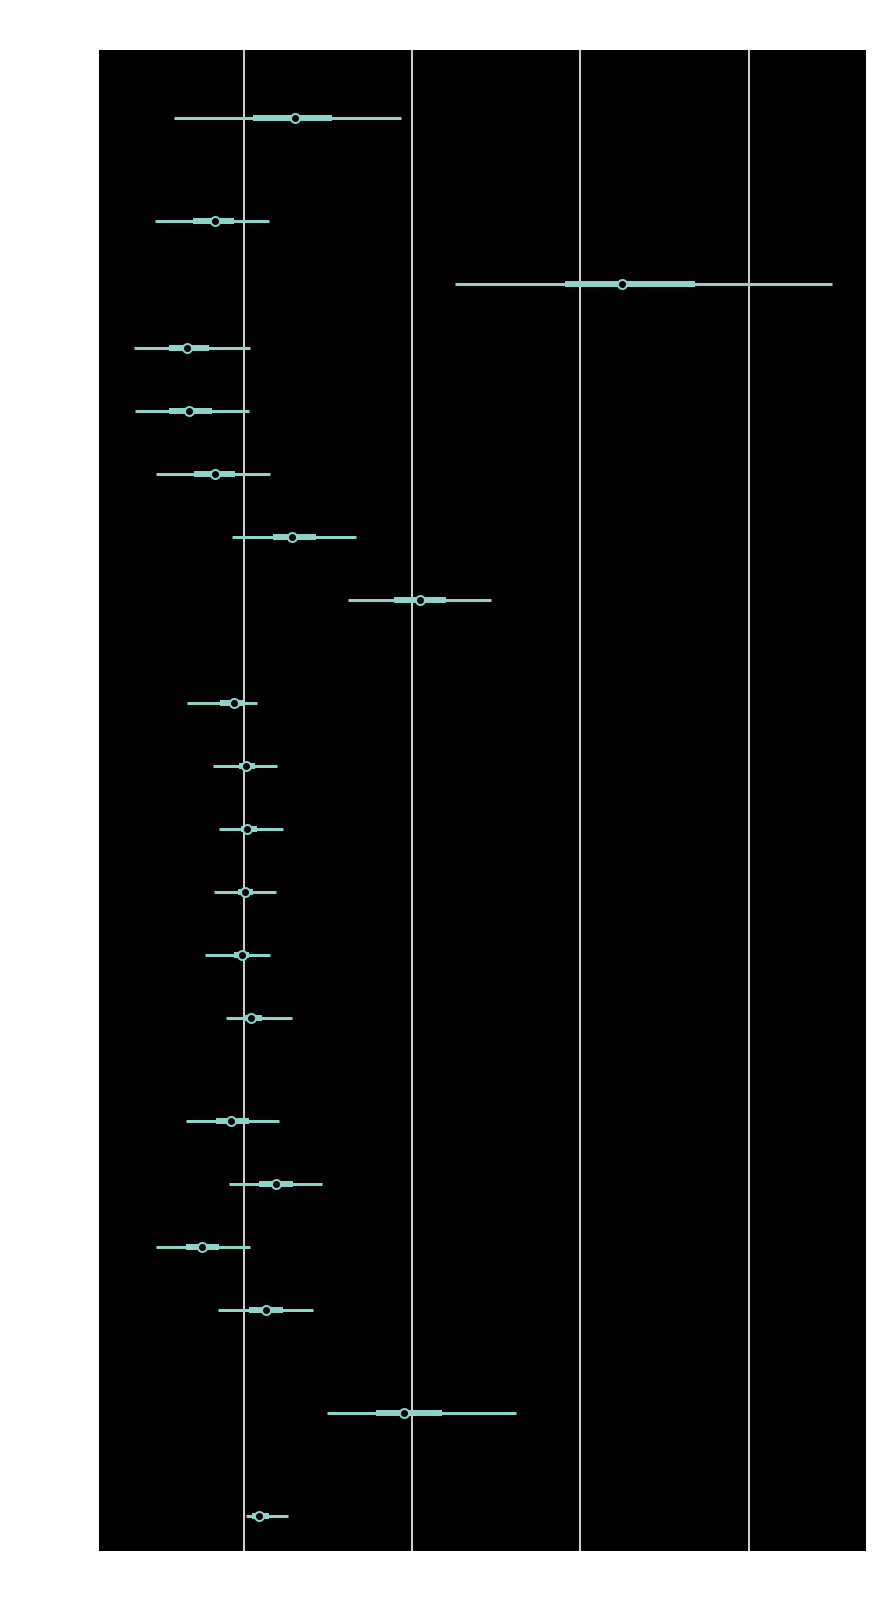

In [19]:
## block has little effect
az.plot_forest(trace4, var_names=["~p"], combined=True)

In [20]:
# same model without block
with pm.Model() as m5:
    a_bar = pm.Normal("a_bar", 0, 1.5) 
    s_a = pm.Exponential("s_a", 1)
    a = pm.Normal("a", a_bar, s_a, shape=len(actors))
    b = pm.Normal("b", 0, 0.5, shape=len(treatments))
    p = pm.Deterministic("p", pm.math.invlogit(a[actor_idx] + b[treatment_idx]))
    L = pm.Binomial("pulled_left", 1, p, observed=d["pulled_left"])
    trace5 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, s_a, a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


In [21]:
## pooling treatment effects is valid, even though it's fixed experimentally
with pm.Model() as m6:
    a_bar = pm.Normal("a_bar", 0, 1.5) 
    s_a = pm.Exponential("s_a", 1)
    s_g = pm.Exponential("s_g", 1) 
    ## just add a common sd for b
    s_b = pm.Exponential("s_b", 1)
    a = pm.Normal("a", a_bar, s_a, shape=len(actors))
    g = pm.Normal("g", 0, s_g, shape=len(blocks))
    ## b's now come from a common distribution
    b = pm.Normal("b", 0, s_b, shape=len(treatments))
    p = pm.Deterministic("p", pm.math.invlogit(a[actor_idx] + g[block_idx] + b[treatment_idx]))
    L = pm.Binomial("pulled_left", 1, p, observed=d["pulled_left"])
    trace6 = pm.sample(tune=2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, s_a, s_g, s_b, a, g, b]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


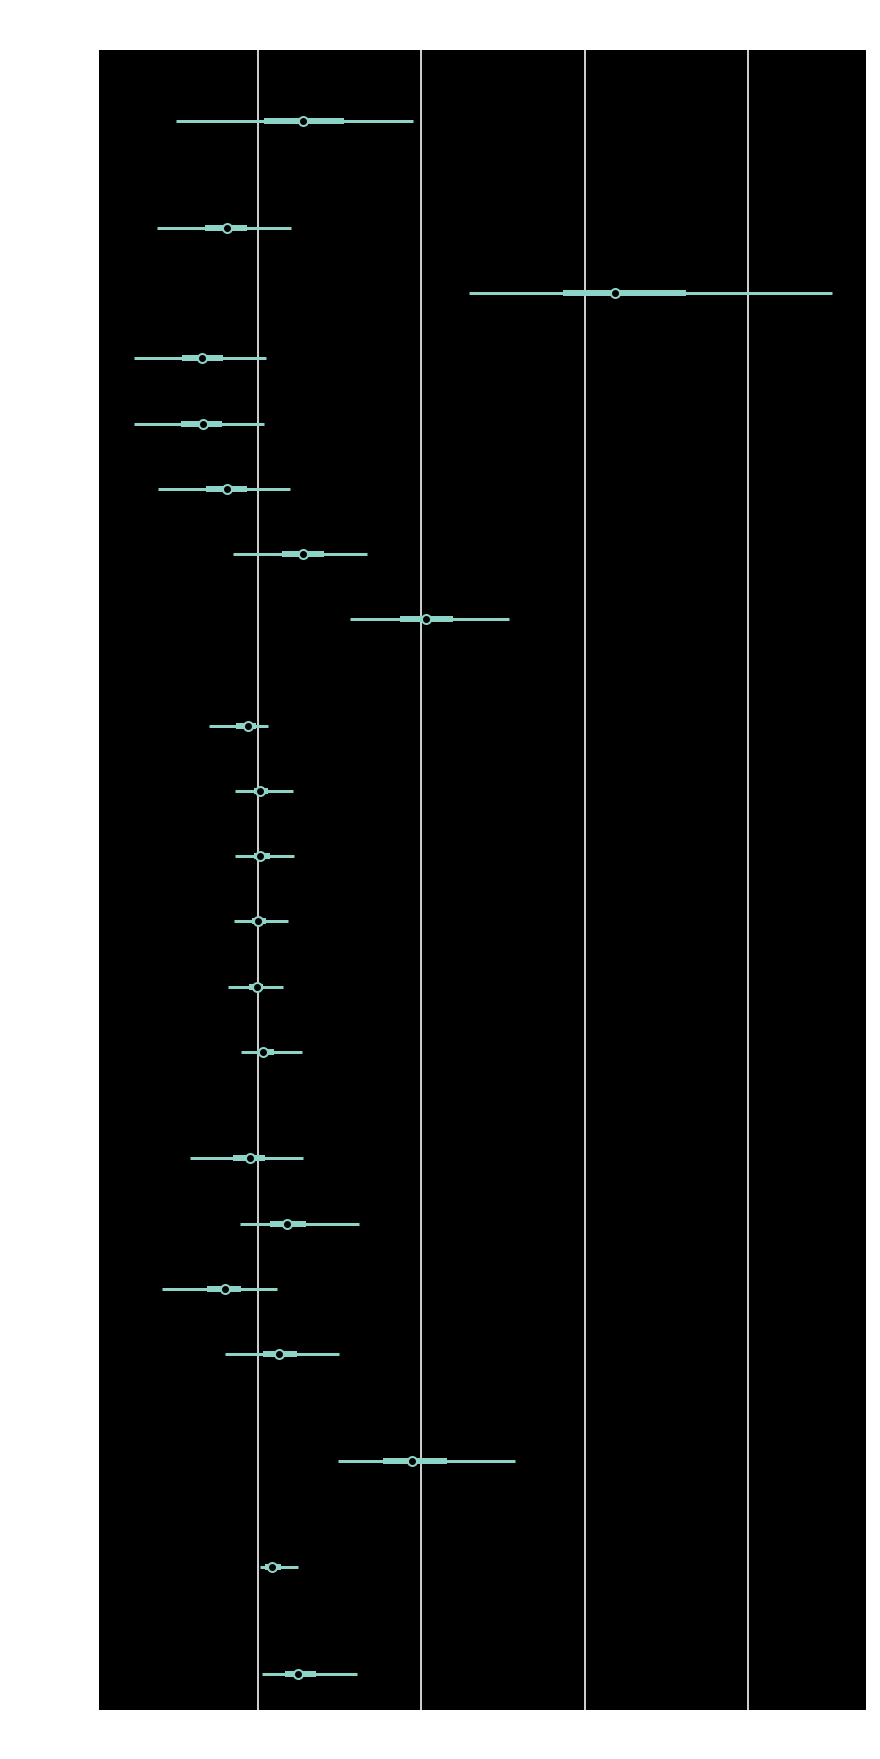

In [24]:
## not much difference because each treatment already contains a lot of data
az.plot_forest(trace6,var_names=['~p'], combined=True);

In [25]:
## note p_waic, number of effective parameters
az.compare({"m4": trace4, "m5": trace5, "m6": trace6},
    ic="waic", scale="deviance", method="BB-pseudo-BMA")

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m5,0,531.259485,8.609503,0.000000,0.503105,20.088183,0.000000,False,deviance
m4,1,532.212417,10.691158,0.952933,0.309152,20.010801,1.739015,False,deviance
m6,2,533.191547,10.919918,1.932063,0.187743,19.932671,1.679959,False,deviance


13.4 better sampling using non-centered parameters

In [7]:
with pm.Model() as m4b:
    a_bar = pm.Normal("a_bar", 0, 1.5) 
    s_a = pm.Exponential("s_a", 1)
    s_g = pm.Exponential("s_g", 1)
    ## a = Normal(a_bar, s_a) = a_bar + Normal(0,1)*s_a
    Z_a = pm.Normal("Z_a", 0, 1, shape=len(actors))
    a = pm.Deterministic("a", a_bar + Z_a * s_a)
    ## g = Normal(0, s_g) = Normal(0,1)*s_g
    Z_g = pm.Normal("Z_g", 0, 1, shape=len(blocks))
    g = pm.Deterministic("g", Z_g * s_g)
    ## now there are no parameters inside distributions
    b = pm.Normal("b", 0, 0.5, shape=len(treatments))
    p = pm.Deterministic("p", pm.math.invlogit(a[actor_idx] + g[block_idx] + b[treatment_idx]))
    L = pm.Binomial("pulled_left", 1, p, observed=d["pulled_left"])
    trace4b = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, s_a, s_g, Z_a, Z_g, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

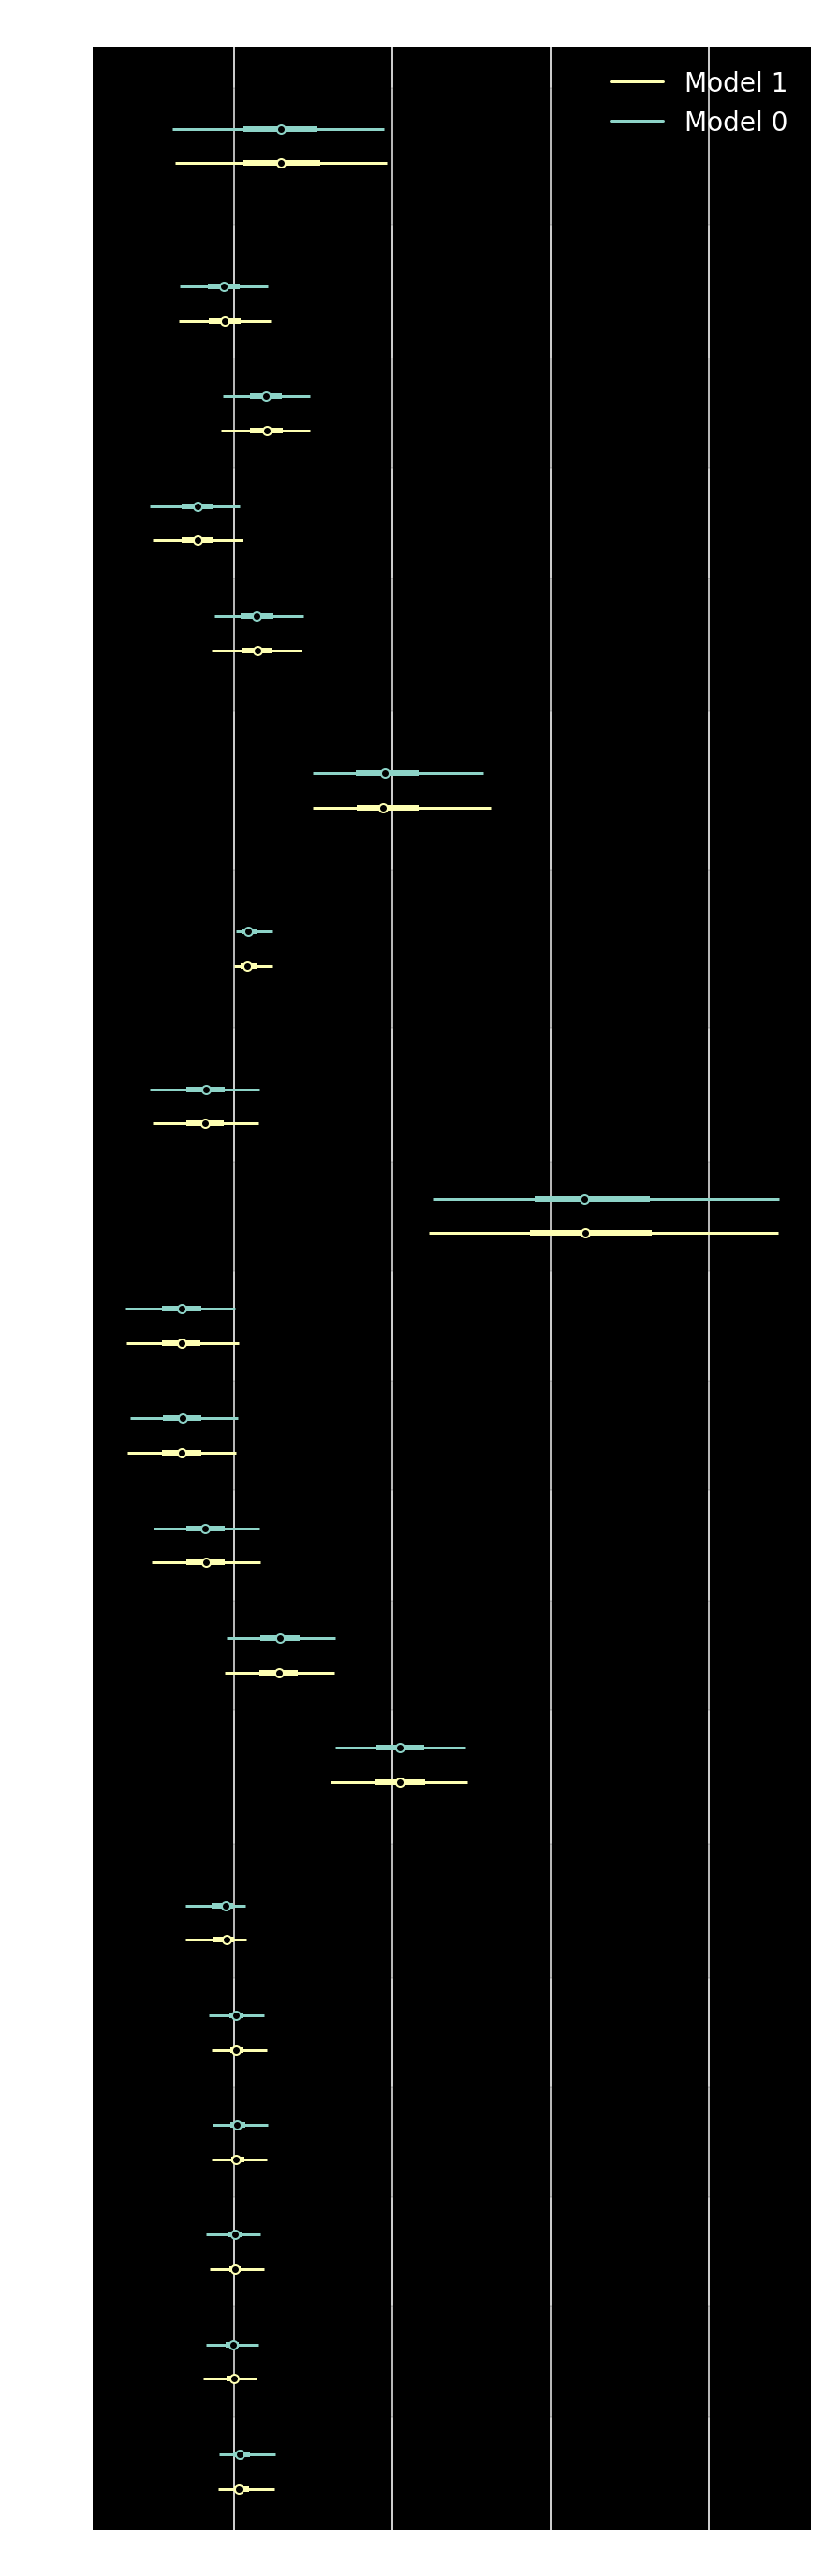

In [41]:
## same
az.plot_forest([trace4, trace4b], var_names=["~p","~Z_a", "~Z_g"], combined=True)

13.5 posterior predictions

In [76]:
with pm.Model() as m134:
    a_bar = pm.Normal("a_bar", 0, 1.5) 
    s_a = pm.Exponential("s_a", 1)
    s_g = pm.Exponential("s_g", 1)
    ## a = Normal(a_bar, s_a) = a_bar + Normal(0,1)*s_a
    Z_a = pm.Normal("Z_a", 0, 1, shape=len(actors))
    a = pm.Deterministic("a", a_bar + Z_a * s_a)
    ## g = Normal(0, s_g) = Normal(0,1)*s_g
    Z_g = pm.Normal("Z_g", 0, 1, shape=len(blocks))
    g = pm.Deterministic("g", Z_g * s_g)
    b = pm.Normal("b", 0, 0.5, shape=len(treatments))
    ## mutable input data for posterior predictions
    actid_ = pm.MutableData("actor", actor_idx)
    blockid_ = pm.MutableData("block", block_idx)
    treatid_ = pm.MutableData("treatment", treatment_idx)
    p = pm.Deterministic("p", pm.math.invlogit(a[actid_] + g[blockid_] + b[treatid_]))
    L = pm.Binomial("pulled_left", 1, p, observed=d["pulled_left"])
    trace134 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, s_a, s_g, Z_a, Z_g, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [100]:
## actor index 1, with block idx fixed at 0, across all treatments
d_pred = {'actor': np.repeat(1,4), 'block': np.repeat(0,4), 'treatment': np.arange(4)}
with m134:
    pm.set_data(d_pred)
    ## note: only sample outcome vars, don't try to sample a posterior var that determines the outcome
    post_pred = pm.sample_posterior_predictive(trace134, var_names=["p","pulled_left"])

In [101]:
az.summary(post_pred)

/Users/sasha/miniforge3/lib/python3.9/site-packages/arviz/stats/stats.py:1366: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.979,0.020,0.943,1.0,0.000,0.000,2806.0,2149.0,1.0
p[1],0.988,0.013,0.965,1.0,0.000,0.000,2908.0,2152.0,1.0
p[2],0.972,0.027,0.921,1.0,0.000,0.000,2828.0,2213.0,1.0
p[3],0.986,0.014,0.961,1.0,0.000,0.000,2638.0,2092.0,1.0
pulled_left[0],0.979,0.144,1.000,1.0,0.002,0.002,3875.0,4000.0,1.0
pulled_left[1],0.989,0.105,1.000,1.0,0.002,0.001,3925.0,4000.0,1.0
pulled_left[2],0.973,0.162,1.000,1.0,0.003,0.002,3900.0,4000.0,1.0
pulled_left[3],0.986,0.116,1.000,1.0,0.002,0.001,3928.0,4000.0,1.0


In [102]:
print(post_pred.posterior_predictive['p'].mean(['chain','draw']))
az.hdi(post_pred.posterior_predictive)['p']

<xarray.DataArray 'p' (p_dim_0: 4)>
array([0.97943165, 0.98762593, 0.97154865, 0.9862953 ])
Coordinates:
  * p_dim_0  (p_dim_0) int64 0 1 2 3


<xarray.DataArray 'p' (p_dim_0: 4, hdi: 2)>
array([[0.94272532, 0.99999792],
       [0.96510972, 0.99999862],
       [0.92142222, 0.99999689],
       [0.96128594, 0.99999864]])
Coordinates:
  * p_dim_0  (p_dim_0) int64 0 1 2 3
  * hdi      (hdi) <U6 'lower' 'higher'

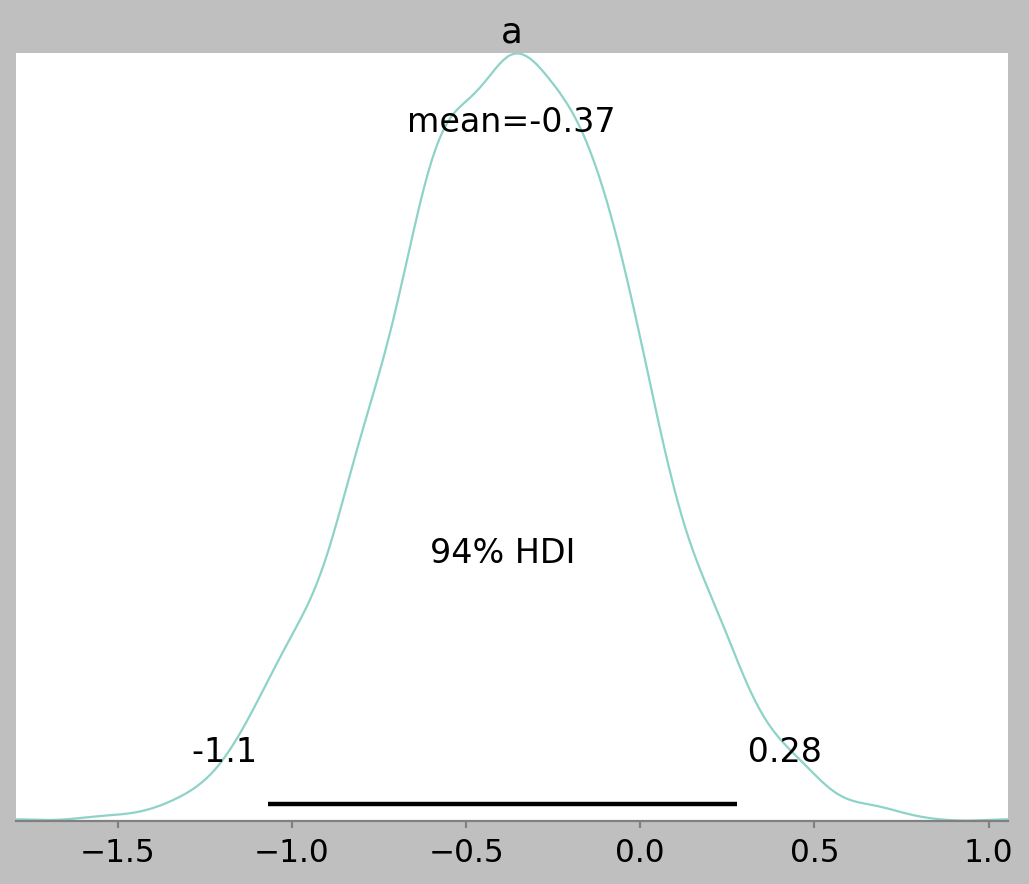

In [103]:
## arviz plot_posterior()
with plt.style.context(style="classic", after_reset=True):
    az.plot_posterior(trace134, var_names=['a'], coords={'a_dim_0': 4}) ## actor index 4

In [112]:
## manually calculate predicted p for actor_idx 1, block_idx 0, all treatments
post = trace134.posterior
post_p_test = logistic(post['b'][:,:,:] + post['a'][:,:,1] + post['g'][:,:,0])
post_p_test

<xarray.DataArray (chain: 4, draw: 1000, b_dim_0: 4)>
array([[[0.99508554, 0.99695542, 0.99347078, 0.99712103],
        [0.99596361, 0.99793962, 0.99317315, 0.99707726],
        [0.99093302, 0.9969491 , 0.98656184, 0.99537855],
        ...,
        [0.9911021 , 0.9889108 , 0.97482084, 0.99123735],
        [0.95709106, 0.9813576 , 0.96581149, 0.97973366],
        [0.993479  , 0.99455739, 0.98586816, 0.99553275]],

       [[0.99939509, 0.99943863, 0.99865018, 0.99947475],
        [0.99855701, 0.99906491, 0.99709946, 0.99852336],
        [0.99855701, 0.99906491, 0.99709946, 0.99852336],
        ...,
        [0.97982794, 0.99003587, 0.97521121, 0.98684479],
        [0.96445213, 0.98730623, 0.96569746, 0.9836744 ],
        [0.98121765, 0.99137088, 0.97933555, 0.9866172 ]],

       [[0.94945194, 0.96776797, 0.94220004, 0.97287901],
        [0.98127964, 0.98787245, 0.95966673, 0.9829392 ],
        [0.95966937, 0.97784674, 0.95688131, 0.98158856],
        ...,
        [0.99583161, 0.99755084, 0.99557163, 0.99767451],
        [0.97011387, 0.98799186, 0.97149325, 0.98329178],
        [0.99651039, 0.99855998, 0.9965736 , 0.99794802]],

       [[0.98195788, 0.99097496, 0.97715235, 0.9883359 ],
        [0.99020759, 0.99420275, 0.98986663, 0.99300725],
        [0.99368695, 0.99660306, 0.9908425 , 0.99724629],
        ...,
        [0.99346708, 0.99651811, 0.9911948 , 0.99608488],
        [0.88860273, 0.92074026, 0.83431705, 0.91938363],
        [0.99827273, 0.99880788, 0.9979155 , 0.99893069]]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * b_dim_0  (b_dim_0) int64 0 1 2 3
    a_dim_0  int64 1
    g_dim_0  int64 0

In [113]:
print(post_p_test.mean(['chain','draw']))
az.hdi(post_p_test)['x']

<xarray.DataArray (b_dim_0: 4)>
array([0.97943165, 0.98762593, 0.97154865, 0.9862953 ])
Coordinates:
  * b_dim_0  (b_dim_0) int64 0 1 2 3
    a_dim_0  int64 1
    g_dim_0  int64 0


<xarray.DataArray 'x' (b_dim_0: 4, hdi: 2)>
array([[0.94272532, 0.99999792],
       [0.96510972, 0.99999862],
       [0.92142222, 0.99999689],
       [0.96128594, 0.99999864]])
Coordinates:
  * b_dim_0  (b_dim_0) int64 0 1 2 3
    a_dim_0  int64 1
    g_dim_0  int64 0
  * hdi      (hdi) <U6 'lower' 'higher'

13.5.2 new clusters (generalizing out of sample)

In [125]:
post = trace134.posterior
## 'average' actor with intercept = a_bar
pred_average_actor = logistic(post['a_bar'] + post['b']) ## + mean block effect (= 0)

<AxesSubplot:>

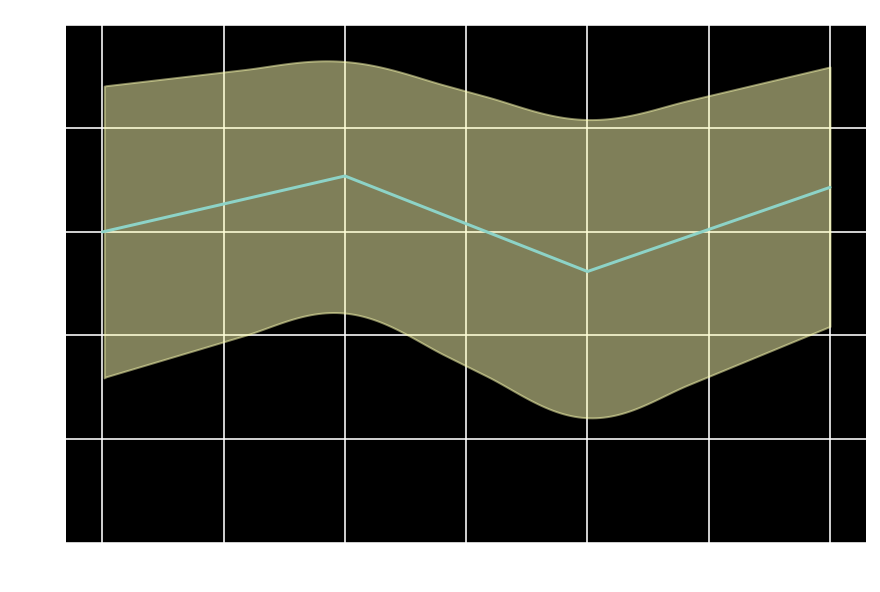

In [128]:
_, ax = plt.subplots()
ax.set_ylim(0,1)
ax.plot(np.arange(4), pred_average_actor.mean(['chain','draw']))
## uncertainty about average actor's intercept and effect of each treatment
az.plot_hdi(np.arange(4), pred_average_actor)

In [187]:
simulated_actors = np.random.normal(post['a_bar'], post['s_a'])
## give the numpy array an extra dimension so it can be broadcast with the DataArray of treatment effects
pred_p_actors = logistic(simulated_actors[:,:,None] + post['b'])

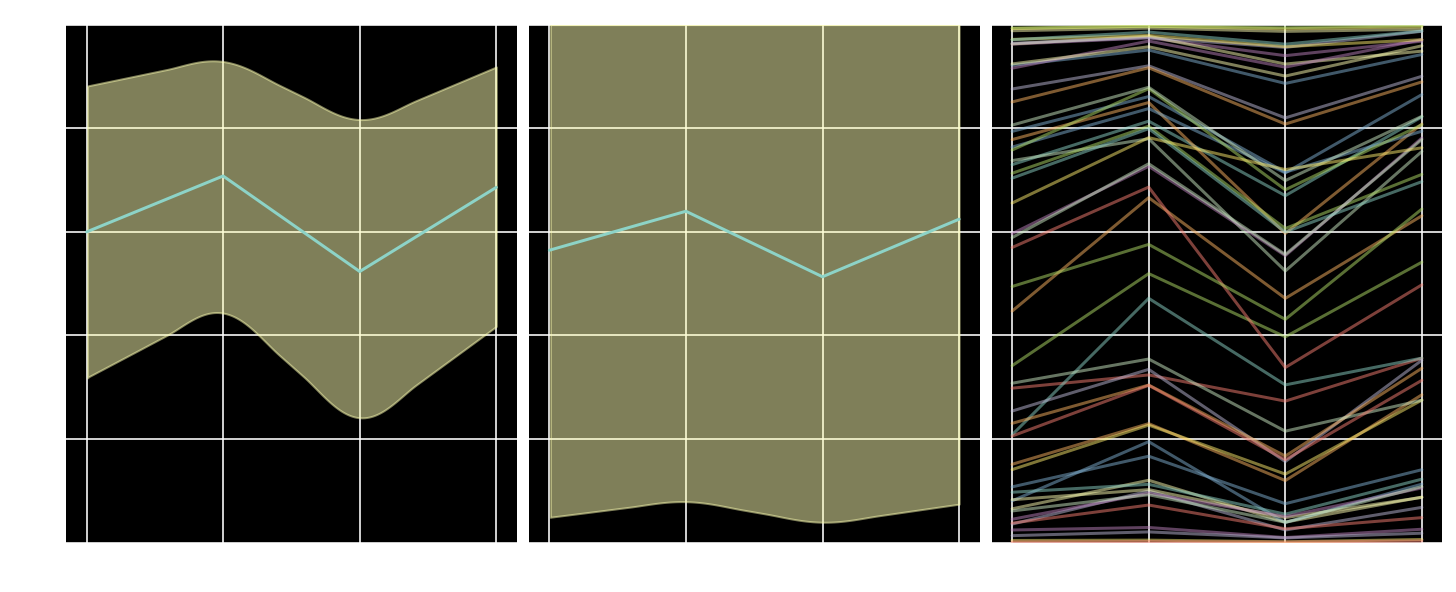

In [211]:
_, ax = plt.subplots(1,3,sharey=True, figsize=(10,4))
ax[0].set_ylim(0,1)
x = np.arange(4)
ax[0].plot(x, pred_average_actor.mean(['chain','draw']))
az.plot_hdi(x, pred_average_actor, ax=ax[0])
## mean of variation among actors = marginal of actor
ax[1].plot(x, pred_p_actors.mean(['chain','draw']))
az.plot_hdi(x, pred_p_actors, ax=ax[1])
## simulated actors
for i in range(50):
    ax[2].plot(x, pred_p_actors[0,i,:], alpha=0.5);